# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 1 - Smoothers and Generalized Additive Models



**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner


<hr style="height:2pt">

### Homework 1 is due February 6th

In [2]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [3]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as sm
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder

# Seaborn visualization library
import seaborn as sns


<hr style="height:2pt">

### Problem 1 - Modeling Seasonality of Airbnb Prices
In this problem, the task is to build a regression model to predict the price of an Airbnb rental for a given date. The data are provided in `calendar_train.csv` and `calendar_test.csv`, which contain availability and price data for a sample of Airbnb units in the Boston area from 2017 to 2018, about 4 observations per day in each set.

Start by loading the data using pandas.  
*Hint*: You likely want to have pandas parse the `date` column as a datetime object via the `parse_dates` argument of `pd.read_csv`

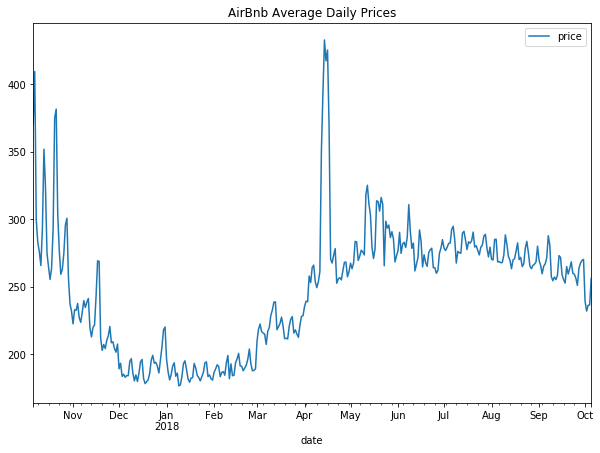

In [5]:
#your code here

#load training data
airbnb_train = pd.read_csv("../data/calendar_train.csv", parse_dates=['date']).dropna()
#airbnb_train = pd.read_csv("data/calendar_train.csv", parse_dates=['date']).dropna()


weekend = np.array(airbnb_train.date.dt.weekday)
friday = weekend == 4
saturday = weekend == 5
airbnb_train['weekend'] = friday + saturday

#load test data
airbnb_test = pd.read_csv("../data/calendar_test.csv", parse_dates=['date']).dropna()
#airbnb_test = pd.read_csv("data/calendar_test.csv", parse_dates=['date']).dropna()

weekend = np.array(airbnb_test.date.dt.weekday)
friday = weekend == 4
saturday = weekend == 5
airbnb_test['weekend'] = friday + saturday

daily_average_train = airbnb_train[['date', 'price', 'weekend']].groupby(by=['date'], sort=True).mean()
daily_average_train.plot(figsize=(10,7), title='AirBnb Average Daily Prices')
plt.show()

### Exploratory Analysis

Visualize the average price by month and day of the week (i.e., Monday, Tuesday, etc.) for the training set. Point out any trends you notice and explain whether or not they make sense.

### Comment

* Average prices are dcidedly higher during the US summer months May through Sep. May could be on account of college graduation and the high concentration of colleges in Boston

* The prices drop by nearly 30% during the winter months which is a bit surprising considering Thanksgiving and Christmas holidays

* Weekend prices are about 15% higher than weekday prices and start to dip on Sunday which is probably on account of the work-week starting Monday.

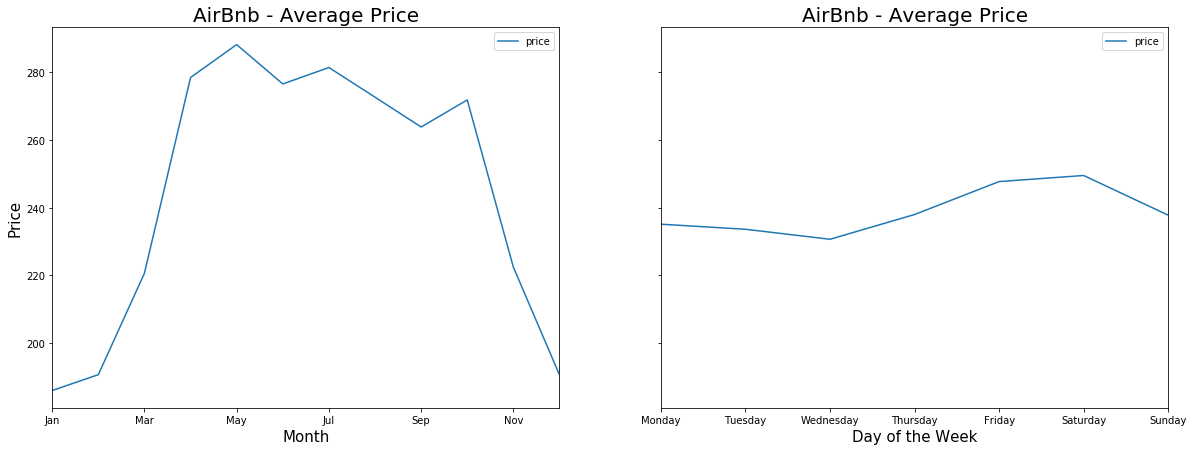

In [4]:
#your code here
import calendar

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)

monthly_average_price = airbnb_train.dropna()[['date', 
                                               'price']].groupby(by=[airbnb_train.date.dt.month],
                                                                 sort=True).mean()
monthly_average_price = monthly_average_price.rename(index=lambda x: calendar.month_abbr[x])
ax1 = monthly_average_price.plot(title='AirBnb - Average Price', figsize=(20,7), ax=ax1)
ax1.title.set_size(20)
ax1.set_xlabel('Month', fontsize=15)
ax1.set_ylabel('Price', fontsize=15)
#plt.show()

days = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday']
day_of_week_average_price = airbnb_train.dropna()[['date', 
                                                   'price']].groupby(by=[airbnb_train.date.dt.weekday_name],
                                                                    ).mean().reindex(days)
ax2 = day_of_week_average_price.plot(title='AirBnb - Average Price', figsize=(20,7), ax=ax2)
ax2.title.set_size(20)
ax2.set_xlabel('Day of the Week', fontsize=15)
ax2.set_ylabel('Price', fontsize=15)
plt.show()

### Explore different regression models

Fit a regression model that uses the date as a predictor and predicts the price of an Airbnb rental on that date. In this section, you should ignore all other predictors besides the date. Fit the following models on the training set, and compare the $R^2$ of the fitted models on the test set. Include plots of the fitted models for each method.

*Hint*: You may want to convert the `date` column into a numerical variable by taking the difference in days between each date and the earliest date in the column.

1. Fit simple polynomial models of degree 2, 3, 5, and 8 to the training data. Provide train and test R^2 scores and provide plot(s) of a) the daily averages and b) each model's predictions.

2. You should see that the degree 8 polynomial's predictions are awful- either nonsensically near zero [or far too large] at many input values. This isn't just simple overfitting. What is going wrong in this model, and how might it be addressed?

3. Fit a Smoothing spline model in `pygam` with the smoothness parameter chosen by cross-validation on the training set. Provide the train and test scores of the best-performing model, and plot its predictions. Also plot the predictions of models with more and less smoothing. When plotting the smooths, show a scatterplot of the daily averages on the same axes, for context.

4. Of the models, which performs the best? What is the effect of the tuning parameters (degree and smoothness penalty)?

In [5]:
#your code here
airbnb_train.date = (airbnb_train.date - airbnb_train.date.min()).dt.days
airbnb_test.date = (airbnb_test.date - airbnb_test.date.min()).dt.days
airbnb_test.head()

,listing_id,date,available,price,weekend
0,21205442,357,t,138.0,True
1,5166870,309,t,210.0,True
12,19455818,189,t,869.0,True
14,20351854,78,t,239.0,True
17,20622324,126,t,259.0,True


### 1. Polynomials


##########################################################
Polynomial Regression with Degree = 2
Training R-Squared                = 0.0185
Testing R-Squared                 = 0.0192


np.vander(date, 3, increasing=True)[0]    206.093239
np.vander(date, 3, increasing=True)[1]      0.079469
np.vander(date, 3, increasing=True)[2]      0.000463
dtype: float64


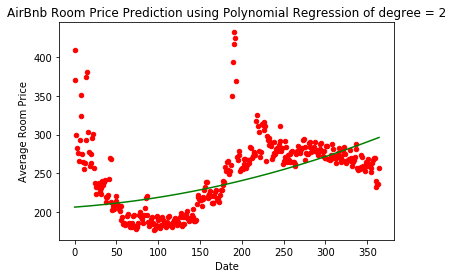


##########################################################
Polynomial Regression with Degree = 3
Training R-Squared                = 0.0389
Testing R-Squared                 = 0.0388


np.vander(date, 4, increasing=True)[0]    297.346254
np.vander(date, 4, increasing=True)[1]     -2.543320
np.vander(date, 4, increasing=True)[2]      0.017967
np.vander(date, 4, increasing=True)[3]     -0.000032
dtype: float64


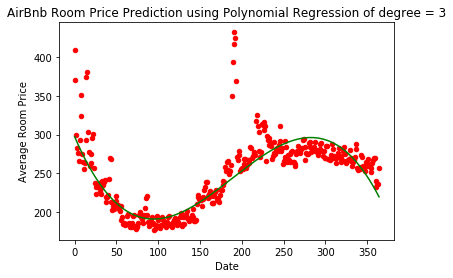


##########################################################
Polynomial Regression with Degree = 5
Training R-Squared                = 0.0421
Testing R-Squared                 = 0.0417


np.vander(date, 6, increasing=True)[0]    3.180886e+02
np.vander(date, 6, increasing=True)[1]   -3.059272e+00
np.vander(date, 6, increasing=True)[2]    1.546791e-02
np.vander(date, 6, increasing=True)[3]    5.116205e-05
np.vander(date, 6, increasing=True)[4]   -4.095472e-07
np.vander(date, 6, increasing=True)[5]    5.842766e-10
dtype: float64


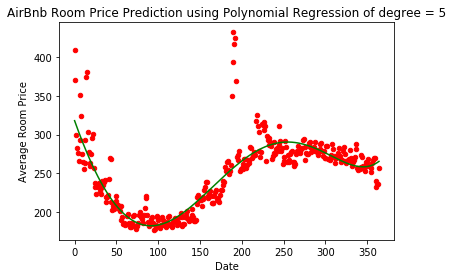


##########################################################
Polynomial Regression with Degree = 8
Training R-Squared                = -0.1702
Testing R-Squared                 = -0.1580


np.vander(date, 9, increasing=True)[0]    6.821108e-09
np.vander(date, 9, increasing=True)[1]    6.820274e-07
np.vander(date, 9, increasing=True)[2]    2.795870e-05
np.vander(date, 9, increasing=True)[3]    1.084525e-03
np.vander(date, 9, increasing=True)[4]   -1.522061e-05
np.vander(date, 9, increasing=True)[5]    8.210840e-08
np.vander(date, 9, increasing=True)[6]   -1.972762e-10
np.vander(date, 9, increasing=True)[7]    1.764673e-13
np.vander(date, 9, increasing=True)[8]    1.623291e-18
dtype: float64


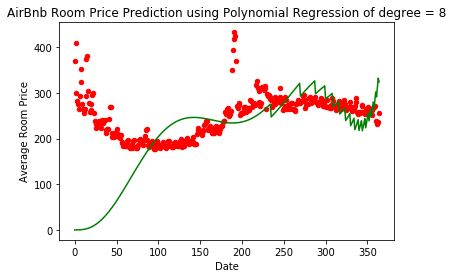


##########################################################


In [6]:
#your code here

degrees = [2, 3, 5, 8]

daily_average_price_train = airbnb_train[['date','weekend',
                                          'price']].groupby(by=[airbnb_train.date], 
                                                            sort=True).mean()
daily_average_price_test = airbnb_test[['date','weekend',
                                        'price']].groupby(by=[airbnb_train.date],
                                                          sort=True).mean()

poly_reg = []

for degree in degrees:
    formula = 'price ~ np.vander(date, {}, increasing=True) - 1'.format(degree+1)
    model = sm.ols(formula=formula, data=airbnb_train).fit()
    print("\n##########################################################")
    print("Polynomial Regression with Degree = {}".format(degree))
    print("Training R-Squared                = {:1.4f}".format(model.rsquared))
    pred_test = model.get_prediction(airbnb_test)
    prediction_output = model.get_prediction(daily_average_price_train).summary_frame()
    print("Testing R-Squared                 = {:1.4f}".format(r2_score(airbnb_test.price, pred_test.predicted_mean)))
    
    print("\n")
    print(model.params)
    
    ax1 = daily_average_price_train.plot.scatter(x='date',y='price',c='Red',
                                                 title="AirBnb Room Price Prediction using Polynomial " +
                                                 "Regression of degree = {}".format(degree))
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Average Room Price")

    ax1.plot(daily_average_price_train.date, prediction_output['mean'],color="green")
    plt.show()
    
print("\n##########################################################")

### 2. Degree 8 oddity

* The coefficients are 


You should see that the degree 8 polynomial's predictions are awful- either nonsensically near zero [or far too large] at many input values. This isn't just simple overfitting. What is going wrong in this model, and how might it be addressed?

### 3. Smoothing spline model with the smoothness parameter chosen by cross-validation on the training set.

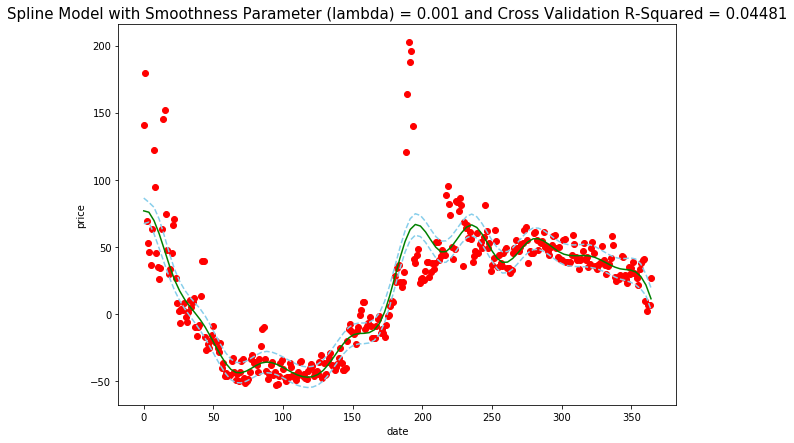

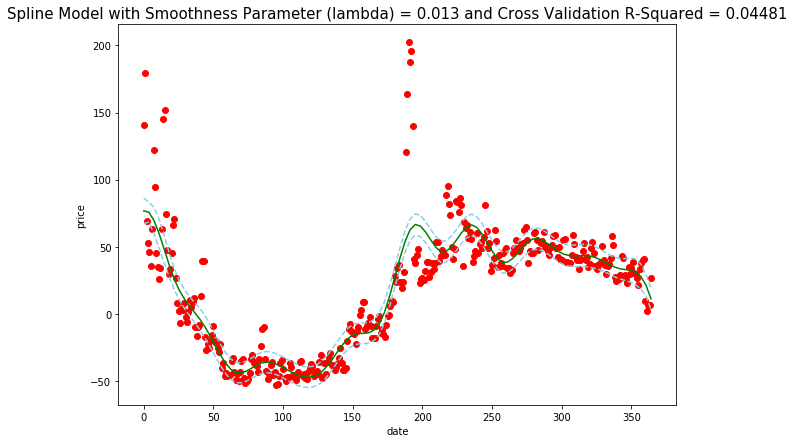

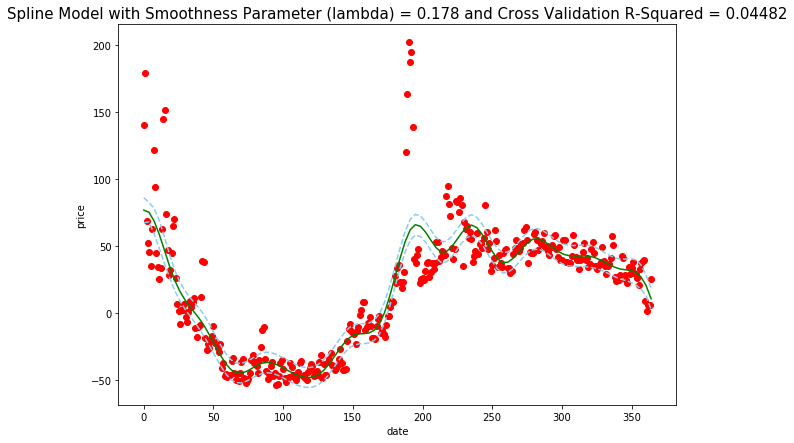

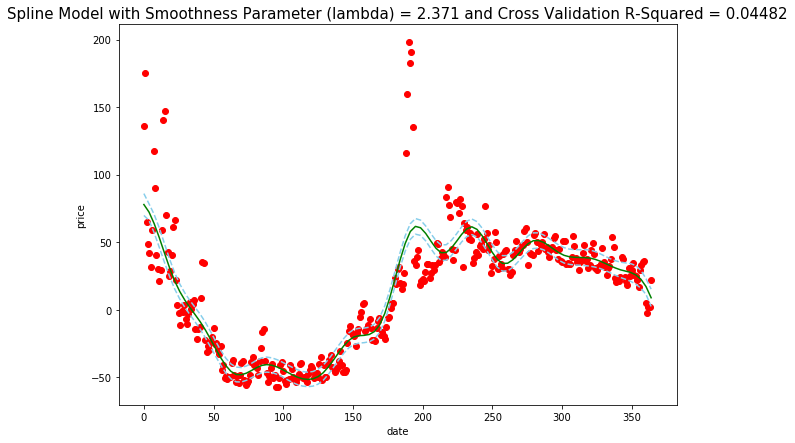

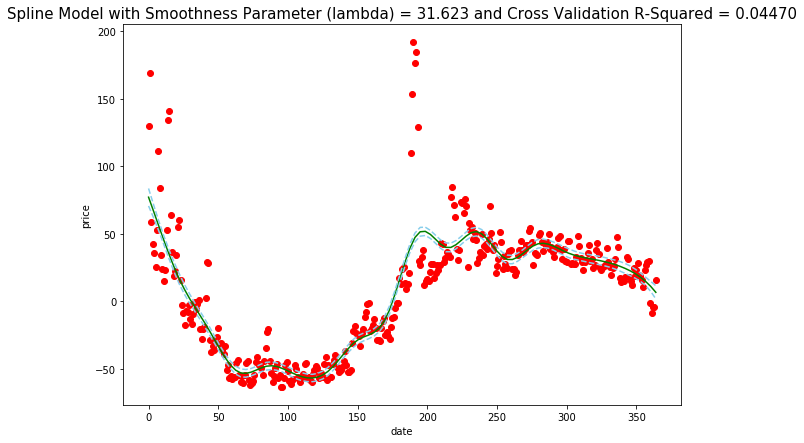

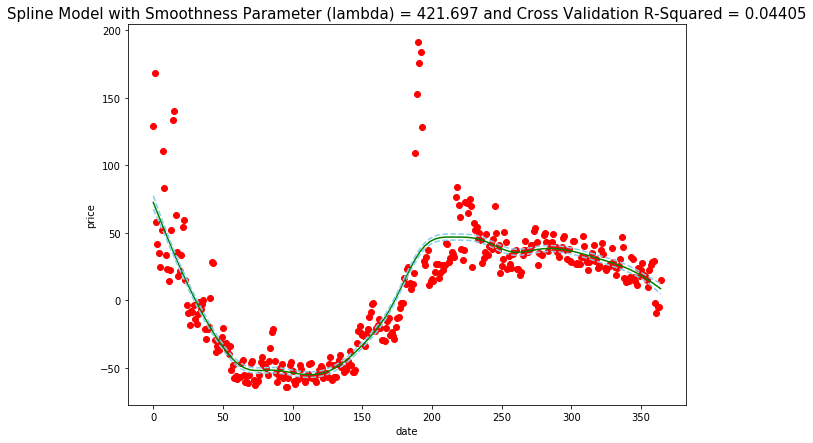

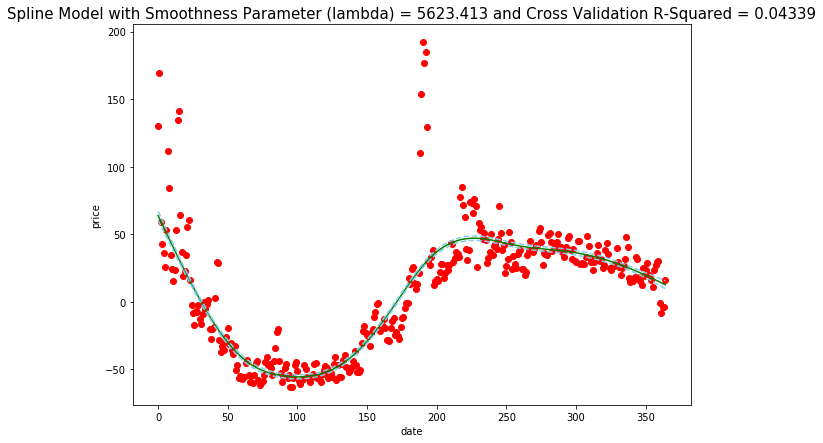

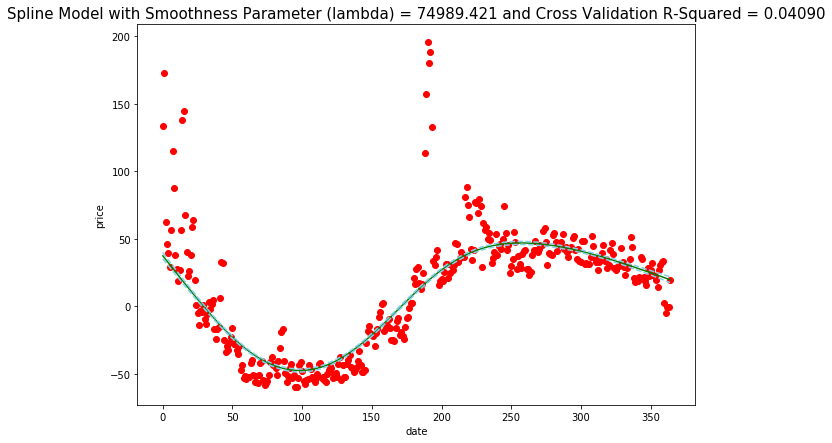

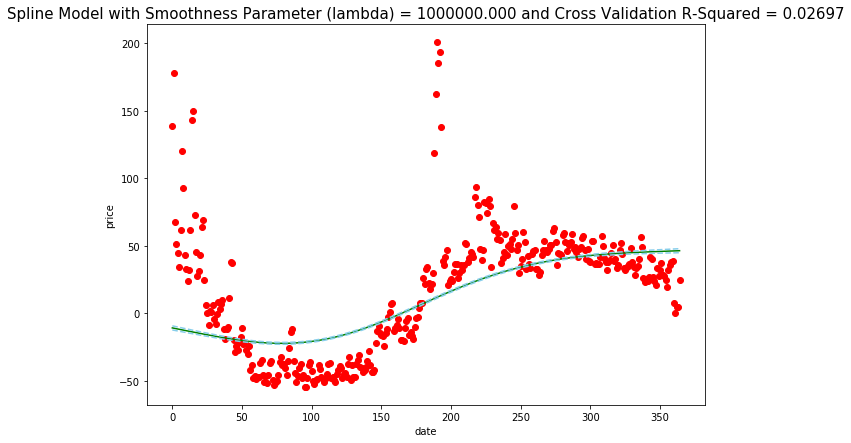

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     19.2091
Link Function:                     IdentityLink Log Likelihood:                              -3510883.8943
Number of Samples:                       309288 AIC:                                          7021808.2068
                                                AICc:                                         7021808.2096
                                                GCV:                                            33950.6166
                                                Scale:                                          33946.8212
                                                Pseudo R-Squared:                                    0.045
Feature Function                  Lam

/usr/share/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



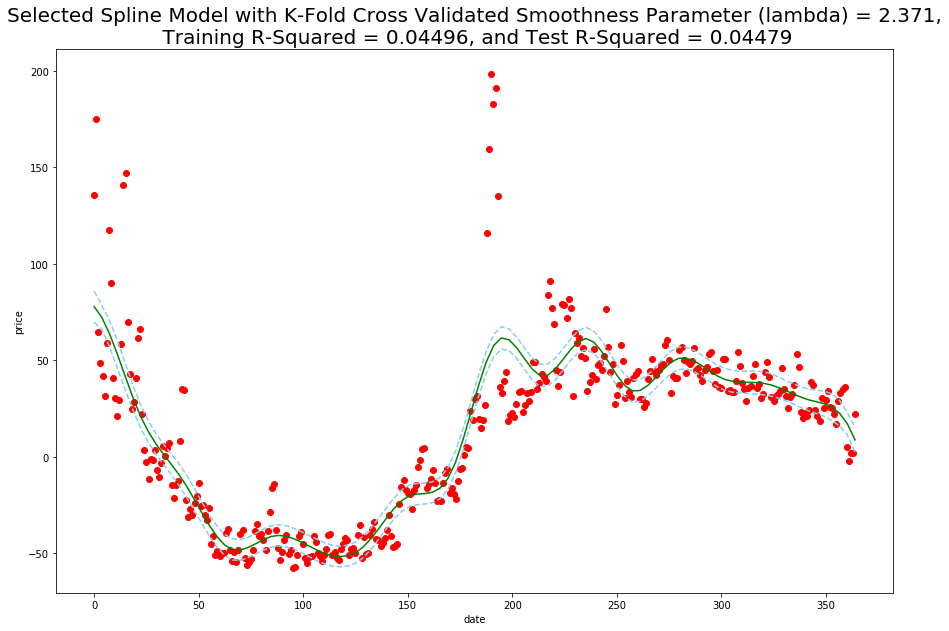

In [7]:
#your code here

smoothings = np.logspace(-3, 6, 9)
cv = 5

kf = KFold(n_splits=cv, random_state=42, shuffle=True)
scores = np.zeros((cv,len(smoothings)))

for i, (train_index, test_index) in enumerate(kf.split(airbnb_train)):
    train_df = airbnb_train.iloc[train_index,:]
    test_df = airbnb_train.iloc[test_index,:]
    
    for j, smoothing in enumerate(smoothings):
        cur_model = LinearGAM(s(0), lam=smoothing).fit(train_df.date, train_df.price)
        scores[i,j] = r2_score(test_df.price, cur_model.predict(test_df.date))


for j, smoothing in enumerate(smoothings):
    cur_model = LinearGAM(s(0), lam=smoothing).fit(airbnb_train.date, airbnb_train.price)
    rscore = np.mean(scores[:,j])
    res = cur_model.deviance_residuals(daily_average_price_train.date, daily_average_price_train.price)

    for k, term in enumerate(cur_model.terms):
        if term.isintercept:
            continue

        XX = cur_model.generate_X_grid(term=k)
        pdep, confi = cur_model.partial_dependence(term=k, X=XX, width=0.95)
        pdep2, _ = cur_model.partial_dependence(term=k, X=daily_average_price_train.date, width=0.95)
        plt.figure(figsize=(10,7))
        plt.scatter(daily_average_price_train.iloc[:,term.feature], pdep2 + res, c='red')
        plt.plot(XX[:, term.feature], pdep, c='green')
        plt.plot(XX[:, term.feature], confi, c='skyblue', ls='--')
        plt.title('Spline Model with Smoothness Parameter (lambda) = ' + 
                  '{:0.3f} and Cross Validation R-Squared = {:0.5f}'.format(smoothing, rscore), fontsize=15)
        plt.xlabel(daily_average_price_train.columns.values[term.feature])
        plt.ylabel('price')
        plt.show()


best_lambda = smoothings[np.argmax(np.mean(scores, axis=0))]

airbnb_gam = LinearGAM(s(0), lam=best_lambda).fit(airbnb_train.date, airbnb_train.price)
r_score_train = r2_score(airbnb_train.price, airbnb_gam.predict(airbnb_train.date))
r_score_test = r2_score(airbnb_test.price, airbnb_gam.predict(airbnb_test.date))

print(airbnb_gam.summary())
print('\n###########################################################\n')
print('Lambda = {:0.3f}'.format(best_lambda))
print('Training R-Squared = {:0.5f}'.format(r_score_train))
print('Testing R-Squared = {:0.5f}'.format(r_score_test))
print('\n###########################################################\n')

res = airbnb_gam.deviance_residuals(daily_average_price_train.date, daily_average_price_train.price)
for i, term in enumerate(airbnb_gam.terms):
    if term.isintercept:
        continue

    XX = airbnb_gam.generate_X_grid(term=i)
    pdep, confi = airbnb_gam.partial_dependence(term=i, X=XX, width=0.95)
    pdep2, _ = airbnb_gam.partial_dependence(term=i, X=daily_average_price_train.date, width=0.95)
    plt.figure(figsize=(15,10))
    plt.scatter(daily_average_price_train.iloc[:,term.feature], pdep2 + res, c='red')
    plt.plot(XX[:, term.feature], pdep, c='green')
    plt.plot(XX[:, term.feature], confi, c='skyblue', ls='--')
    plt.title('Selected Spline Model with K-Fold Cross Validated Smoothness Parameter (lambda) = ' +
              '{:0.3f},\n Training R-Squared = {:0.5f}, and Test R-Squared = {:0.5f}'.format(best_lambda, 
                                                                                             r_score_train, 
                                                                                             r_score_test),
              fontsize=20)
    
    plt.xlabel(daily_average_price_train.columns.values[term.feature])
    plt.ylabel('price')
    plt.show()

### 4. Effects of parameters
_your answer here_

### Part 1b: Adapting to weekends

It is possible/likely that prices on weekends (Friday nights and Saturday nights) are systematically higher than prices on weekdays, and that including this aspect of the data-generating process in our model will produce a better fit.

5. Create a binary indicator of weekend versus non-weekend, and include it in your best-performing model from above. How does it impact the model's performance?  
*Hint*: include a categorical variable in a GAM by importing and using `pygam.f` in the same way you've used `pygam.s` for continuous variables.



###########################################################

Training R-Squared = 0.04611
Testing R-Squared = 0.04615

###########################################################

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     20.2089
Link Function:                     IdentityLink Log Likelihood:                              -3510511.3437
Number of Samples:                       309288 AIC:                                          7021065.1051
                                                AICc:                                         7021065.1081
                                                GCV:                                             33909.943
                                                Scale:                

/usr/share/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  # This is added back by InteractiveShellApp.init_path()


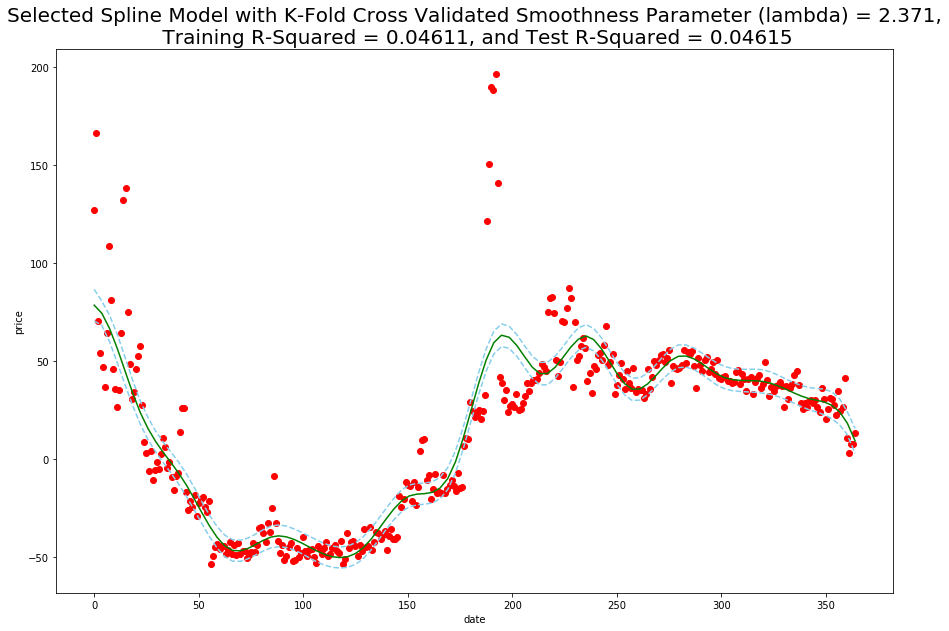

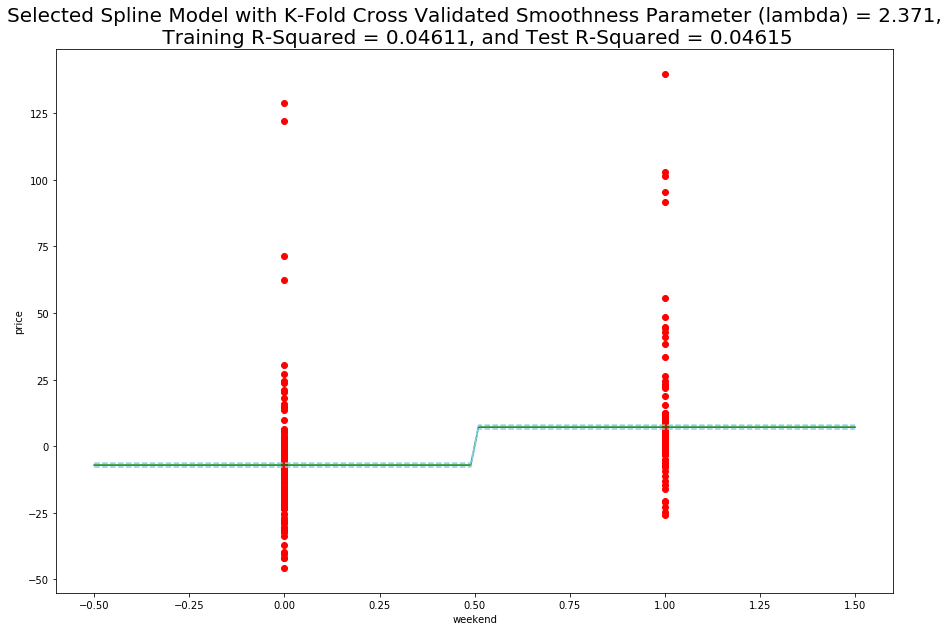

In [8]:
#your code here

airbnb_gam = LinearGAM(s(0) + f(1), lam=best_lambda).fit(airbnb_train[['date','weekend']], airbnb_train.price)
r_score_train = r2_score(airbnb_train.price, airbnb_gam.predict(airbnb_train[['date','weekend']]))
r_score_test = r2_score(airbnb_test.price, airbnb_gam.predict(airbnb_test[['date','weekend']]))

print('\n###########################################################\n')
print('Training R-Squared = {:0.5f}'.format(r_score_train))
print('Testing R-Squared = {:0.5f}'.format(r_score_test))
print('\n###########################################################\n')
print(airbnb_gam.summary())

res = airbnb_gam.deviance_residuals(daily_average_price_train[['date','weekend']], daily_average_price_train.price)
for i, term in enumerate(airbnb_gam.terms):
    if term.isintercept:
        continue

    XX = airbnb_gam.generate_X_grid(term=i)
    pdep, confi = airbnb_gam.partial_dependence(term=i, X=XX, width=0.95)
    pdep2, _ = airbnb_gam.partial_dependence(term=i, X=daily_average_price_train[['date','weekend']], width=0.95)
    plt.figure(figsize=(15,10))
    plt.scatter(daily_average_price_train.iloc[:,term.feature], pdep2 + res, c='red')
    plt.plot(XX[:, term.feature], pdep, c='green')
    plt.plot(XX[:, term.feature], confi, c='skyblue', ls='--')
    plt.title('Selected Spline Model with K-Fold Cross Validated Smoothness Parameter (lambda) = ' +
              '{:0.3f},\n Training R-Squared = {:0.5f}, and Test R-Squared = {:0.5f}'.format(best_lambda,
                                                                                             r_score_train, 
                                                                                             r_score_test), 
              fontsize=20)
    
    plt.xlabel(daily_average_price_train.columns.values[term.feature])
    plt.ylabel('price')
    plt.show()

### Part 1c: Going the Distance

You may have noticed from your scatterplots of average price versus day on the training set that there are a few days with abnormally high average prices.

Sort the training data in decreasing order of average price, extracting the 10 most expensive dates. Why are the prices on these days so high? Is it something about the days themselves, noise, an artifact of data collection, or something else?

In [9]:
#your code here

daily_average_train.sort_values(by=['price'], ascending=False).head(10)

,price,weekend
date,,
2018-04-14,432.680761,True
2018-04-16,425.289528,False
2018-04-15,417.170404,False
2017-10-07,409.298701,True
2018-04-13,393.609047,True
2017-10-21,381.526515,True
2017-10-20,374.955932,True
2017-10-06,370.173410,True
2018-04-17,369.371060,False


### Comment 1c

* April 13 through 17 prices are high which is likely on account of the Boston Marathon and 
* The other high rates are close to weekends and could be on account of some events or random concentrations due to different factors.

### Problem 2: Predicting Airbnb Rental Price Through Listing Features

In this problem, we'll continue our exploration of Airbnb data by predicting price based on listing features. The data can be found in `listings_train.csv` and `listings_test.csv`.

First, visualize the relationship between each of the predictors and the response variable. Does it appear that some of the predictors have a nonlinear relationship with the response variable?

In [9]:
#your code here

#load training data
#listing_train = pd.read_csv("../data/listings_train.csv").dropna()

listing_train = pd.read_csv("data/listings_train.csv").dropna()

#load test data
#listing_test = pd.read_csv("../data/listings_test.csv").dropna()

listing_test = pd.read_csv("data/listings_test.csv").dropna()
print("Shape: ", listing_train.shape)
listing_train.head()

Shape:  (4370, 12)


,host_total_listings_count,room_type,latitude,longitude,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,availability_365,number_of_reviews
0,1,Private room,42.347956,-71.155196,1.0,1,1,52,1,65,365,26
1,85,Entire home/apt,42.349299,-71.083470,1.0,0,1,110,1,104,107,38
2,6,Entire home/apt,42.341902,-71.073792,1.0,1,1,67,45,56,322,9
3,1,Entire home/apt,42.319235,-71.105016,2.0,2,2,103,8,113,341,49
4,1,Entire home/apt,42.346452,-71.134896,1.0,0,1,8,24,82,41,13


In [ ]:
sns.set()

category = ["room_type", "bedrooms", "bathrooms", "beds"]

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(20,45))

for i, col in enumerate(category):
    sns.boxplot(x=col, y="price", hue="room_type", data=listing_train, ax=ax[i])
    if col == 'room_type':
        continue
    #sns.lmplot(x=col, y="price", data=listing_train);
    #sns.relplot(x=col, y="price", col="room_type", hue="beds", data=listing_train)

fig.show()

numerics = ["host_total_listings_count", "security_deposit", "cleaning_fee", "availability_365", "number_of_reviews"]
for col in numerics:
    sns.lmplot(x=col, y="price", col="room_type", order=1, sharex=False, ci=None, x_estimator=np.mean, robust=True,
               data=listing_train);


sns.pairplot(listing_train, hue="room_type")

### Part 2a: Polynomial Regression

Fit the following models on the training set and compare the $R^2$ score of the fitted models on the test set:
    
* Linear regression
* Regression with polynomial basis functions of degree 3 (i.e., basis functions $x$, $x^2$, $x^3$ for each predictor $x$) for quantitative predictors.

In [11]:
listing_train.head(n=2) # delete before submission

,host_total_listings_count,room_type,latitude,longitude,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,availability_365,number_of_reviews
0,1,Private room,42.347956,-71.155196,1.0,1,1,52,1,65,365,26
1,85,Entire home/apt,42.349299,-71.083470,1.0,0,1,110,1,104,107,38


In [12]:
#your code here
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

train_list = listing_train.drop(labels=['room_type'], axis=1)
test_list = listing_test.drop(labels=['room_type'], axis=1)

room_type = OneHotEncoder(drop='first', sparse=False).fit(listing_train.room_type.to_numpy().reshape(-1,1))
room_type_train = pd.DataFrame(room_type.transform(listing_train.room_type.to_numpy().reshape(-1,1)))
room_type_test = pd.DataFrame(room_type.transform(listing_test.room_type.to_numpy().reshape(-1,1)))
room_type_train.columns = 'room_type' + room_type_train.columns.astype(str)
room_type_test.columns = 'room_type' + room_type_test.columns.astype(str)

train_lin = pd.concat([room_type_train, train_list], axis=1)
test_lin = pd.concat([room_type_test, test_list], axis=1)

terms = [x for x in train_lin.columns if x != 'price']
formula = "+".join(terms)
formula = 'price ~ {}'.format(formula)

reg = sm.ols(formula=formula, data=train_lin).fit()

r_score_train = r2_score(train_lin.price, reg.predict(train_lin))
r_score_test = r2_score(test_lin.price, reg.predict(test_lin))

print('\n###########################################################\n')
print("Linear Regression - Using One Hot Encoding")
print('Training R-Squared = {:0.5f}'.format(r_score_train))
print('Testing R-Squared = {:0.5f}'.format(r_score_test))
print('\n###########################################################\n')
print(reg.summary())


room_type = LabelEncoder().fit(listing_train.room_type.to_numpy().reshape(-1,1))
room_type_train = pd.DataFrame({'room_type': room_type.transform(listing_train.room_type.to_numpy().reshape(-1,1))})
room_type_test = pd.DataFrame({'room_type': room_type.transform(listing_test.room_type.to_numpy().reshape(-1,1))})

train_lin2 = pd.concat([room_type_train, train_list], axis=1)
test_lin2 = pd.concat([room_type_test, test_list], axis=1)

terms2 = [x for x in train_lin2.columns if x != 'price']
formula = "+".join(terms2)
formula = 'price ~ {}'.format(formula)

reg = sm.ols(formula=formula, data=train_lin2).fit()

r_score_train = r2_score(train_lin2.price, reg.predict(train_lin2))
r_score_test = r2_score(test_lin2.price, reg.predict(test_lin2))

print('\n###########################################################\n')
print("Linear Regression - Using Label Encoding")
print('Training R-Squared = {:0.5f}'.format(r_score_train))
print('Testing R-Squared = {:0.5f}'.format(r_score_test))
print('\n###########################################################\n')
print(reg.summary())


poly = PolynomialFeatures(degree=3, include_bias=False)
train_poly = pd.DataFrame(poly.fit_transform(train_list.drop(labels=['price'], axis=1)))
test_poly = pd.DataFrame(poly.transform(test_list.drop(labels=['price'], axis=1)))
train_poly.columns = 'poly' + train_poly.columns.astype(str)
test_poly.columns = 'poly' + test_poly.columns.astype(str)
train_poly['price'] = train_list.price
test_poly['price'] = test_list.price


train_poly = pd.concat([room_type_train, train_poly], axis=1)
test_poly = pd.concat([room_type_test, test_poly], axis=1)

terms3 = [x for x in train_poly.columns if x != 'price']
formula = "+".join(terms3)
formula = 'price ~ {}'.format(formula)

poly_reg = sm.ols(formula=formula, data=train_poly).fit()

r_score_train = r2_score(train_poly.price, poly_reg.predict(train_poly))
r_score_test = r2_score(test_poly.price, poly_reg.predict(test_poly))

print('\n###########################################################\n')
print("Polynomial Regression - Using Label Encoding")
print('Training R-Squared = {:0.5f}'.format(r_score_train))
print('Testing R-Squared = {:0.5f}'.format(r_score_test))
print('\n###########################################################\n')
print(poly_reg.summary())


###########################################################

Linear Regression - Using One Hot Encoding
Training R-Squared = 0.24942
Testing R-Squared = 0.18479

###########################################################

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     120.7
Date:                Tue, 04 Feb 2020   Prob (F-statistic):          1.45e-260
Time:                        13:50:03   Log-Likelihood:                -26307.
No. Observations:                4370   AIC:                         5.264e+04
Df Residuals:                    4357   BIC:                         5.272e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                            

/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



###########################################################

Linear Regression - Using Label Encoding
Training R-Squared = 0.24159
Testing R-Squared = 0.18134

###########################################################

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     126.2
Date:                Tue, 04 Feb 2020   Prob (F-statistic):          7.01e-252
Time:                        13:50:04   Log-Likelihood:                -26330.
No. Observations:                4370   AIC:                         5.268e+04
Df Residuals:                    4358   BIC:                         5.276e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                              

### Part 2b: Generalized Additive Model (GAM)

1. Do you see any advantage in fitting an additive regression model to these data, compared to the above models?

1. Fit a GAM to the training set, and compare the test $R^2$ of the fitted model to the above models. You may use a smoothing spline basis function on each predictor, with the same smoothing parameter for each basis function, tuned using cross-validation on the training set.

2. Plot and examine the smooth of each predictor for the fitted GAM. What are some useful insights conveyed by these plots?


### Answer 2b 1.

There is a merit since the following variables all have a non-linear relationship with price

1. Room type - Entire house prices are much lower thant those of private or shared rooms. This suggests the present of different functions depending on room type; this can be seen in boxplot of room type with prices above (1st Plot)

2. Bedrooms - For private rooms there is a wide variation from $50 to $300 (almost 6X) while entire home prices seem to be gradually increasing with number of bedrooms. The wide distribution for 6 rooms could be on account of location. These 2 factors having a combined effect on price which varies by values of both factors is another reason to explore GAMs (2nd Plot)

3. Bathrooms - A similar effect is seen when bathrooms are compared with price and stratified on room_type. We can see 3 different trend lines in plot 3 and this supports the use of GAMs (3rd Plot)

4. Beds - A similar effect is seen when beds are compared with price and stratified on room_type. We can see 3 different trend lines in plot 3 and this supports the use of GAMs (4th Plot). Also, the trends of effect on price across all plots from plot 1 to plot 4 are markedly different and non-linear depending on the factor on the x-axis which suggests that there is benefit from exploring GAMs


In [13]:
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder


In [14]:
x = train_lin2.drop(labels = ['price'], axis = 1)
x.head()


,room_type,host_total_listings_count,latitude,longitude,bathrooms,bedrooms,beds,security_deposit,cleaning_fee,availability_365,number_of_reviews
0,1,1,42.347956,-71.155196,1.0,1,1,1,65,365,26
1,0,85,42.349299,-71.083470,1.0,0,1,1,104,107,38
2,0,6,42.341902,-71.073792,1.0,1,1,45,56,322,9
3,0,1,42.319235,-71.105016,2.0,2,2,8,113,341,49
4,0,1,42.346452,-71.134896,1.0,0,1,24,82,41,13


In [55]:
y = pd.DataFrame(listing_train['price'])
y.head()

,price
0,52
1,110
2,67
3,103
4,8


In [56]:
lin_gam = LinearGAM(f(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10)).fit(x,y)
# 1st term is a factor term and rest are spline terms
lin_gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    118.2114
Link Function:                     IdentityLink Log Likelihood:                                 -44062.746
Number of Samples:                         4370 AIC:                                            88363.9148
                                                AICc:                                           88370.6589
                                                GCV:                                            10034.7447
                                                Scale:                                           9547.3485
                                                Pseudo R-Squared:                                    0.297
Feature Function                  Lam

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  This is separate from the ipykernel package so we can avoid doing imports until


In [57]:
res = lin_gam.deviance_residuals(x,y)

In [58]:
lin_gam.terms # just to see; delete before submission

f(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + intercept

In [59]:
lin_gam1 = LinearGAM().fit(x,y)
lin_gam1.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    118.2202
Link Function:                     IdentityLink Log Likelihood:                                -44062.7569
Number of Samples:                         4370 AIC:                                            88363.9544
                                                AICc:                                           88370.6995
                                                GCV:                                            10034.8081
                                                Scale:                                           9547.3724
                                                Pseudo R-Squared:                                    0.297
Feature Function                  Lam

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  


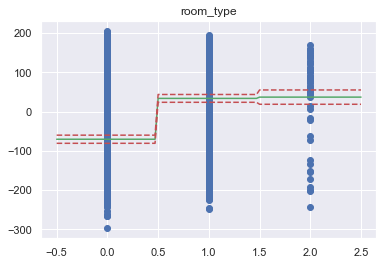

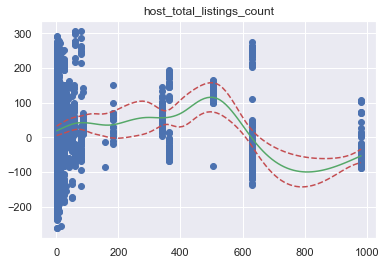

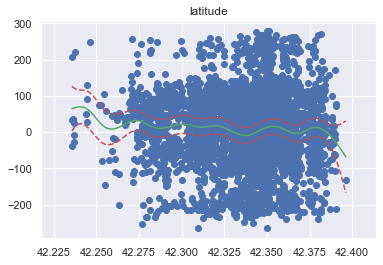

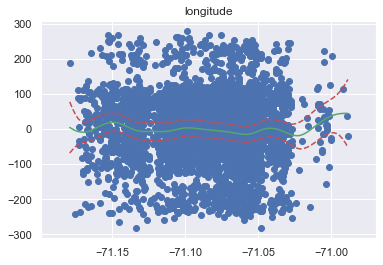

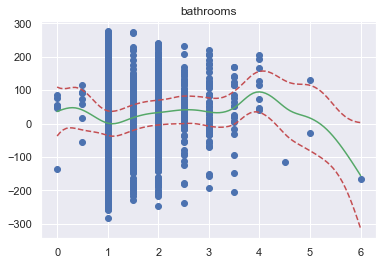

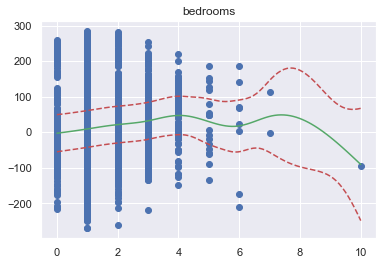

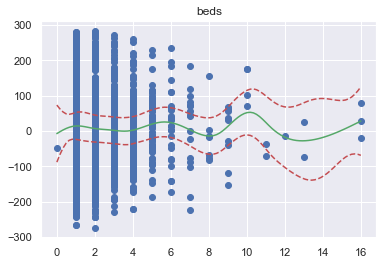

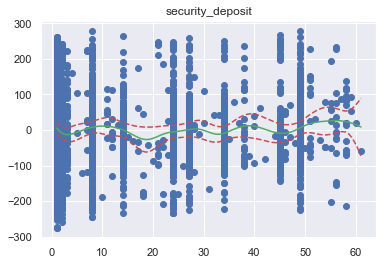

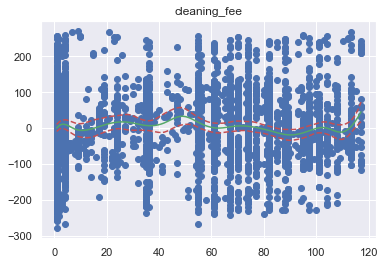

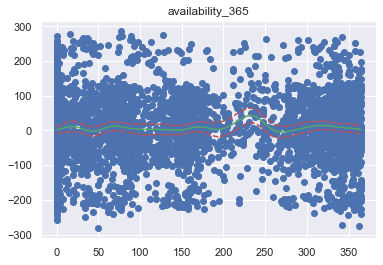

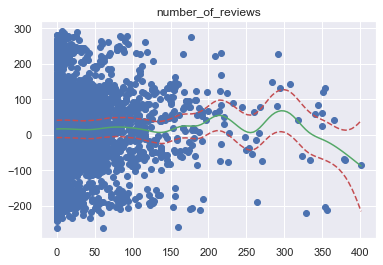

In [60]:
for i, term in enumerate(lin_gam1.terms):
    if term.isintercept:
        continue
    
    xx = lin_gam.generate_X_grid(term = i)
    pdep, confi = lin_gam.partial_dependence(term = i, X = xx, width = 0.95)
    pdep2, _ = lin_gam.partial_dependence(term = i, X = x, width = 0.95)
    
    plt.figure()
    plt.scatter(x.iloc[:, term.feature], pdep2 + res)
    plt.plot(xx[:, term.feature], pdep, c = 'g')
    plt.plot(xx[:, term.feature], confi, c = 'r', ls = '--')
    plt.title(x.columns.values[term.feature])
    plt.show()


In [95]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

lam_ = np.linspace(1, 50, 20) # equally spaced intervals - start, stop, step
folds = 5 # k-folds input

In [96]:
kf = KFold(n_splits = folds, random_state = 666, shuffle = True)
scores = np.zeros((folds, len(lam_)))

In [97]:
scores.shape

(5, 20)

In [98]:
for i, (train_index, test_index ) in enumerate(kf.split(x)):
    train_df = x.iloc[train_index,:]
    train_pred = y.iloc[train_index,:]
    
    test_df = x.iloc[test_index, :]
    test_pred = y.iloc[test_index, :]
    for j, lam_val in enumerate(lam_):
        cur_model = LinearGAM(f(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10), lam = lam_val).fit(train_df, train_pred) 
        scores[i,j] = r2_score(test_pred, cur_model.predict(test_df))



In [99]:
a = np.mean(scores, axis = 0)
print(a)
np.argmax(a)

[0.25049692 0.2546692  0.2560901  0.25684322 0.25730951 0.25762102
 0.25783765 0.25799127 0.2581007  0.25817787 0.25823081 0.25826509
 0.25828472 0.25829267 0.25829118 0.25828194 0.25826629 0.25824528
 0.25821973 0.25819031]


13

In [101]:
# fit using max value

lin_gam_final = LinearGAM(f(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10), lam = lam_[np.argmax(a)]).fit(x,y)
lin_gam_final.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     64.0133
Link Function:                     IdentityLink Log Likelihood:                                -44099.6608
Number of Samples:                         4370 AIC:                                            88329.3481
                                                AICc:                                           88331.3424
                                                GCV:                                             9888.7294
                                                Scale:                                           9628.3375
                                                Pseudo R-Squared:                                    0.282
Feature Function                  Lam

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  after removing the cwd from sys.path.


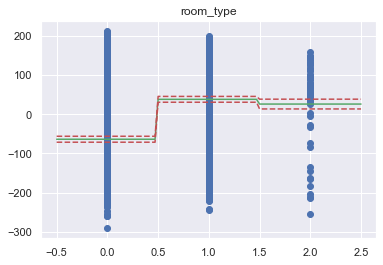

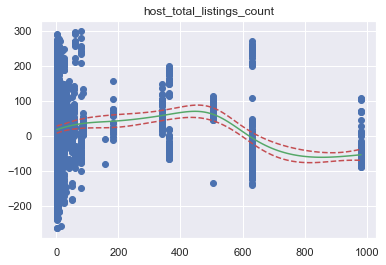

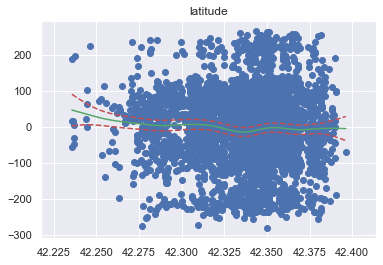

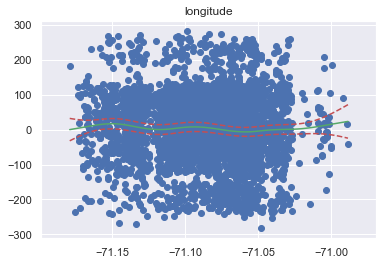

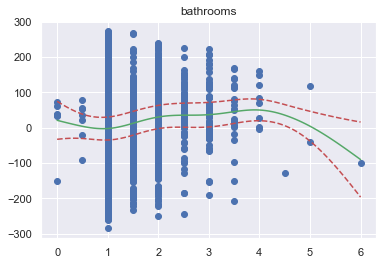

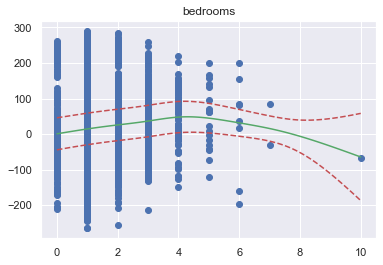

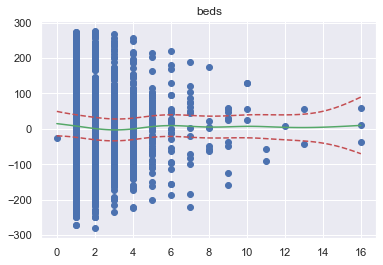

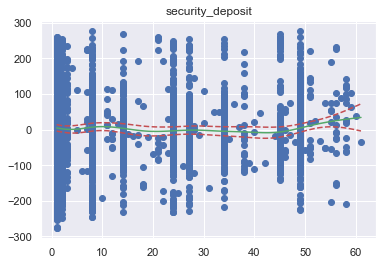

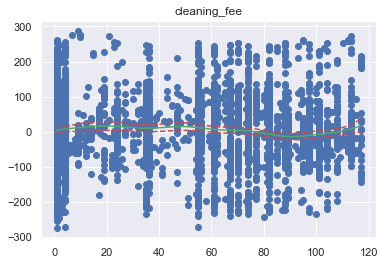

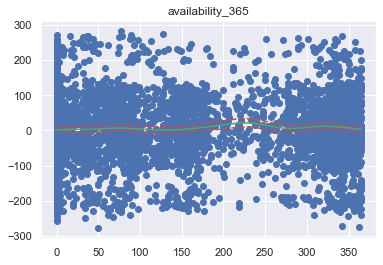

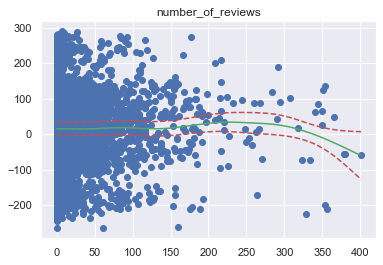

In [102]:
for i, term in enumerate(lin_gam_final.terms):
    if term.isintercept:
        continue
    
    xx = lin_gam_final.generate_X_grid(term = i)
    pdep, confi = lin_gam_final.partial_dependence(term = i, X = xx, width = 0.95)
    pdep2, _ = lin_gam_final.partial_dependence(term = i, X = x, width = 0.95)
    
    plt.figure()
    plt.scatter(x.iloc[:, term.feature], pdep2 + res)
    plt.plot(xx[:, term.feature], pdep, c = 'g')
    plt.plot(xx[:, term.feature], confi, c = 'r', ls = '--')
    plt.title(x.columns.values[term.feature])
    plt.show()
  

room type taken as a factor has a non-linear relationship with price
total listings count also has a similar non-linear effect on the price with price decreasing with increasing listings - pointing to the presence of "airbnb landlords"
latitue and longitude are fairly non-linear in their relationship
bedroms and bathrooms both have an initially increasing and subsequently decreasing relaitonship
except for number of reviews; all other factors appear to have linear relationships.

* Fit a GAM to the training set, and compare the test  𝑅2  of the fitted model to the above models. 

* You may use a smoothing spline basis function on each predictor, with the same smoothing parameter for each basis function, tuned using cross-validation on the training set.

### Part 2c: Putting it All Together
Using the GAM outputs and insights from part 1), discuss the most important variables in the driving prices, and give advide to a frugal traveller hoping to visit Boston.

Average prices are dcidedly higher during the US summer months May through Sep. May could be on account of college graduation and the high concentration of colleges in Boston. This is on account of weekdays and weekends both.

A similar trend is observed in mid-November possibly on account of Thanksgiving.

The prices drop by nearly 30% during the winter months which is a bit surprising considering Christmas holidays but weather is possibly a dominating factor.

Weekend prices are about 15% - 20% higher than weekday prices and start to dip on Sunday which is probably on account of the work-week starting Monday.

* April 13 through 17 prices are high which is likely on account of the Boston Marathon 

* Type of room, Number of reviews and Number of beds, bathrooms and bedrooms are all factors that appear to have a non-linear relationship with Price.
* All these factors seem to affect price differently depending on type of room.

There is a merit since the following variables all have a non-linear relationship with price and there is some amount of interaction between them as well.

1. Room type - Entire house prices are much lower thant those of private or shared rooms. This suggests the present of different functions depending on room type; this can be seen in boxplot of room type with prices above (1st Plot)


2. Bedrooms - For private rooms there is a wide variation from USD 50 to USD 300 (almost 6X) while entire home prices seem to be gradually increasing with number of bedrooms. The wide distribution for 6 rooms could be on account of location. These 2 factors having a combined effect on price which varies by values of both factors is another reason to explore GAMs (2nd Plot)


3. Bathrooms - A similar effect is seen when bathrooms are compared with price and stratified on room_type. We can see 3 different trend lines in plot 3 and this supports the use of GAMs (3rd Plot)


4. Beds - A similar effect is seen when beds are compared with price and stratified on room_type. We can see 3 different trend lines in plot 3 and this supports the use of GAMs (4th Plot). Also, the trends of effect on price across all plots from plot 1 to plot 4 are markedly different and non-linear depending on the factor on the x-axis which suggests that there is benefit from exploring GAMs
